In [8]:
import json
import jellyfish
import re

In [9]:
def get_json(path):
    f = open(path,encoding="utf-8")
    liste = json.load(f, strict=False)
    f.close()
    return liste

In [ ]:
def get_closest(title, number = 10, lowercase=True, 
                path_compare ="data/all_burlesque_pages_corrected.json", word_filter = True,
                seuil_simil = False, javeliser = False):
    """ 
  En entrée, une chaîne de caractère et en option :
    le nombre de titres proches à retourner, par défaut : 10
    mettre en minuscules, par défaut: non
    le chemin des documents à comparer
    word_filter: premier filtre sur le nombre de mots en commun (impact sur le temps de calcul ?)
    seuil_simil: si activé (flottant) on ne donne que les docs au delà du seuil
  En sortie, la liste triée par ordre décroissant de similarité sous forme d'un triplet:
    distance, ID_moreau, titre concerné
  """
    liste_depart = get_json(path_compare)
    #all_burlesque_pages_original_ocr.json
    #all_burlesque_pages_ocr_without_linebreak.json
    #all_burlesque_pages_corrected_without_linebreak.json
    #all_burlesque_pages_corrected.json
    #all_burlesque_pages_ocr_without_space.json
    liste=[]
    if lowercase==True:
        for i in liste_depart:
            liste.append(word.lower() for word in i)
    mots_titre = set(title.split())
    filtered_list = []
    for ID, chaine in  liste:
        mots_candidat = set(chaine.split())
        inter = mots_titre.intersection(mots_candidat)
    ##Si moins de 5 mots en commun (ou de la moitié) inutile de garder le candidat
        if len(inter)>5 or len(inter)>(len(mots_titre)/2) or word_filter==False:
            filtered_list.append([len(inter), ID, chaine])
    f2 = []
    for len_inter, ID, chaine in filtered_list:
        if javeliser==True:
            title  = re.sub("\n| {2,}", " ", title)
            chaine = re.sub("\n| {2,}", " ", chaine)
        sim = jellyfish.jaro_winkler(title,chaine)
    ## On garde quand la similarité est supérieure à 0.5
        f2.append([sim, ID, chaine])
    if seuil_simil!=False:
        f2 = [x for x in f2 if x[0]>seuil_simil]
    return sorted(f2, reverse=True)[:number]

In [55]:
path_ocr = "data/all_burlesque_pages_original_ocr.json"
path_clean = "data/all_burlesque_pages_corrected.json"

In [56]:
l_ocr = get_json(path_ocr)
l_clean = get_json(path_clean)

In [79]:
#OK_first = donne les stats de bons résultats en première position
#found = donne les stats quand la page est trouvée hors de la première position
#Intersection = donne le nombre de résultats en commun pour chaque individu de l'échantillon
def update(dic_res, ID, liste_id_res_ocr, liste_id_res_clean):
  pos_ocr, pos_clean = -1, -1
  if ID.lower() in liste_id_res_ocr:
    pos_ocr = liste_id_res_ocr.index(ID.lower())
    dic_res[filter_status]["found"]["ocr"]+=1
  if ID.lower() in liste_id_res_clean:
    pos_clean = liste_id_res_clean.index(ID.lower()) 
    dic_res[filter_status]["found"]["clean"]+=1
    if ID.lower() in liste_id_res_ocr:
      dic_res[filter_status]["found"]["both"]+=1
  has_error= True
  if pos_ocr ==0:
    dic_res[filter_status]["OK_first"]["ocr"]+=1
    has_error=False
  if pos_ocr==pos_clean:
    dic_res[filter_status]["OK_first"]["both"]+=1
    if pos_ocr ==0:
        dic_res[filter_status]["OK_first"]["both_first"]+=1
  if pos_clean ==0:
    dic_res[filter_status]["OK_first"]["clean"]+=1
  en_commun = set(liste_id_res_ocr).intersection(set(liste_id_res_clean))    
  dic_res[filter_status]["intersections"].append(len(en_commun))
  return dic_res, has_error

import time

for echantillon in [len(l_ocr)-1]:
  dic_res = {True  : {"OK_first":{"ocr":0, "clean":0, "both":0, "both_first":0}, 
                      "found": {"ocr":0, "clean":0, "both":0}, "intersections" : [] },
           False : {"OK_first":{"ocr":0, "clean":0, "both":0, "both_first":0}, 
                    "found": {"ocr":0, "clean":0, "both":0}, "intersections" : [] }}
  print(f"Echantillon={echantillon}")
 #Lancement de la fonction avec et sans le paramètre des 5 mots
  for filter_status in [False, True]:
    start = time.time()
    for i in range(echantillon):#Requête
      if i%100==0:
        print(f"Exemple N° {i}")
      ID, texte = l_ocr[i]
      res_ocr = get_closest(texte, lowercase=True, path_compare = path_ocr, word_filter = filter_status)
      liste_id_res_ocr = [x[1] for x in res_ocr]
      res_clean = get_closest(texte, lowercase=True, path_compare = path_clean, word_filter = filter_status)
      liste_id_res_clean = [x[1] for x in res_clean]
      dic_res, has_error = update(dic_res, ID, liste_id_res_ocr, liste_id_res_clean)
      if has_error==True:
        pos_ocr, pos_ocr2 = -1, -1
        if pos_ocr in liste_id_res_ocr:
          pos_ocr = liste_id_res_ocr.index(ID.lower())
        res_ocr2 = get_closest(texte, javeliser = True, number = 10000000,  lowercase=True, path_compare = path_ocr, word_filter = filter_status)
        liste_id_res_ocr2 = [x[1] for x in res_ocr]
        if pos_ocr2 in liste_id_res_ocr2:
            pos_ocr2 = liste_id_res_ocr2.index(ID.lower())
        len_req = len(texte)
        print(f"ID : {ID} (len={len_req})" )
        if len_req==0:
            continue
        try:
          print(" res_base: ",pos_ocr,  res_ocr[pos_ocr][0])
          print(" ----%s---"%res_ocr[0][2][:50])

        except:
          print(" res_base :None")
        try:
          print(" res_étendu : ",pos_ocr2, res_ocr2[pos_ocr2][0])
          print(" ----%s---"%res_ocr2[pos_ocr][2][:50])
        except:
          print(" res_étendu :None")
                      
    end = time.time()
    
    print(f"Durée (filter={filter_status}):", end-start)
    print(" ", dic_res[filter_status]["OK_first"])
    print("*"*30)


Echantillon=1204
Exemple N° 0
ID : GALL_bpt6k1048495m.xml_1 (len=295)
 res_base:  -1 0.6097075673926869
 ---- 2 le j re lt 1 ll. dl l de ttndli i i iva f l del---
 res_étendu :  -1 0.0
 -------
ID : GALL_bpt6k1168510n.xml_17 (len=0)
ID : GALL_bpt6k1168510n.xml_27 (len=243)
 res_base:  -1 0.6062119251711683
 ----
les ¬ t a 3. 7 ¬ ¬ i9 rov 7 n a maarin apreſté p---
 res_étendu :  -1 0.0
 -------
ID : GALL_bpt6k1168510n.xml_28 (len=0)
ID : GALL_bpt6k1168510n.xml_43 (len=279)
 res_base:  -1 0.6402127738075367
 ----

le dixiesme 7 t v i l francois. tradvit fidel le---
 res_étendu :  -1 0.0
 -------
ID : GALL_bpt6k1168510n.xml_44 (len=0)
ID : GALL_bpt6k1168510n.xml_59 (len=254)
 res_base:  -1 0.6243392757747195
 ----
les ¬ t a 3. 7 ¬ ¬ i9 rov 7 n a maarin apreſté p---
 res_étendu :  -1 0.0
 -------
ID : GALL_bpt6k1168510n.xml_60 (len=0)
Exemple N° 100
ID : GALL_bpt6k1168510n.xml_74 (len=10)
 res_base:  -1 0.6395445134575569
 ----
[bandeau]---
 res_étendu :  -1 0.0
 -------
ID : GALL_bpt6k1

Exemple N° 1000
ID : GALL_bpt6k5707774k.xml_2 (len=0)
ID : GALL_bpt6k5707977h.xml_2 (len=0)
ID : GALL_bpt6k5707978x.xml_1 (len=354)
 res_base:  -1 0.6551362922681344
 ----lettre   de   la   signora 
                fovtar---
 res_étendu :  -1 0.0
 -------
ID : GALL_bpt6k5707978x.xml_2 (len=0)
ID : GALL_bpt6k57083110.xml_2 (len=0)
ID : GALL_bpt6k5710032x.xml_2 (len=0)
ID : GALL_bpt6k5710061n.xml_2 (len=0)
ID : GALL_bpt6k5710203w.xml_2 (len=0)
ID : GALL_bpt6k5719985z.xml_2 (len=0)
ID : GALL_bpt6k5722005x.xml_2 (len=0)
ID : GALL_bpt6k5722057n.xml_2 (len=0)
ID : GALL_bpt6k57481m.xml_2 (len=0)
Exemple N° 1100
ID : GALL_bpt6k58149528.xml_2 (len=0)
ID : GALL_bpt6k58488238.xml_2 (len=0)
ID : GALL_bpt6k5849463q.xml_2 (len=0)
ID : GALL_bpt6k5851782w.xml_2 (len=0)
ID : GALL_bpt6k725697.xml_7 (len=0)
ID : GALL_bpt6k8570137.xml_2 (len=0)
ID : GALL_bpt6k857089x.xml_2 (len=0)
ID : GALL_bpt6k95984c.xml_1 (len=255)
 res_base:  -1 0.6081136441817555
 ----rddie
                    1 aa hi afa l l il bacc

ID : GALL_bpt6k857089x.xml_2 (len=0)
ID : GALL_bpt6k95984c.xml_2 (len=0)
ID : GALL__bpt6k5425912c.xml_3 (len=0)
Exemple N° 1200
Durée (filter=True): 1565.3812918663025
  {'ocr': 1079, 'clean': 883, 'both': 1000, 'both_first': 880}
******************************


In [40]:
dic_res2 = dic_res


In [42]:
"""Attention, 'both' mesure les accords, y compris 'négatifs'--> -1 dans les deux cas (hors résultats)
ça compte un accord
"""
import statistics as stats
print(dic_res2)
for filter_status in dic_res2.keys():
  print(f"Word filter : {filter_status}")
  intersections = dic_res[filter_status]["intersections"]
  NB_pages = len(intersections)
  precision = dic_res[filter_status]["OK_first"]["both"]/NB_pages 
#Proportion des items pertinents parmi l'ensemble des items proposés = mesure de l'exactitude ou de la qualité
  rappel   = dic_res[filter_status]["found"]["both"]/NB_pages
    #la proportion des items pertinents proposés parmi l'ensemble des items pertinents = mesure de l'exhaustivité ou de la quantité
  print(f"  Précision (sur le premier)   : {precision} (support = {NB_pages}) ")
  print(f"  Rappel   (sur les n premiers): {rappel} (support = {NB_pages}) ")
  moyenne   = stats.mean(intersections)
  ecartType = stats.stdev(intersections)
  print(f"  Taille de l'intersection : {moyenne} (+-{ecartType})")

{True: {'OK_first': {'ocr': 95, 'clean': 83, 'both': 87}, 'found': {'ocr': 96, 'clean': 88, 'both': 96}, 'intersections': [1, 0, 2, 6, 6, 6, 8, 8, 1, 6, 6, 7, 5, 1, 7, 5, 6, 7, 6, 5, 5, 8, 5, 6, 6, 6, 7, 6, 7, 5, 4, 8, 0, 3, 3, 4, 2, 3, 1, 1, 4, 6, 2, 7, 6, 3, 6, 0, 0, 1, 1, 1, 2, 2, 3, 5, 7, 4, 0, 0, 2, 2, 3, 2, 2, 4, 2, 6, 1, 5, 2, 6, 6, 7, 1, 0, 5, 3, 1, 2, 1, 6, 3, 3, 3, 3, 2, 2, 8, 5, 0, 0, 2, 3, 1, 6, 2, 5, 3, 1]}, False: {'OK_first': {'ocr': 92, 'clean': 83, 'both': 87}, 'found': {'ocr': 96, 'clean': 88, 'both': 96}, 'intersections': [0, 2, 2, 6, 6, 6, 8, 8, 1, 6, 6, 7, 5, 1, 7, 5, 6, 7, 6, 5, 5, 8, 5, 6, 6, 6, 7, 6, 7, 5, 4, 7, 0, 3, 3, 4, 2, 3, 1, 1, 4, 6, 2, 7, 6, 3, 7, 1, 0, 1, 1, 1, 2, 2, 3, 5, 7, 4, 1, 0, 2, 2, 3, 2, 2, 4, 2, 6, 1, 5, 2, 6, 6, 6, 0, 0, 5, 3, 1, 2, 1, 6, 3, 3, 3, 3, 2, 2, 8, 5, 0, 0, 2, 3, 1, 6, 2, 5, 3, 1]}}
Word filter : True
  Précision (sur le premier)   : 0.87 (support = 100) 
  Rappel   (sur les n premiers): 0.96 (support = 100) 
  Taille de l'interse

In [15]:
print(dic_res)

{True: {'OK_first': {'ocr': 6, 'clean': 4, 'both': 4}, 'found': {'ocr': 6, 'clean': 4, 'both': 6}, 'intersections': [1, 0, 2, 6, 6, 6]}, False: {'OK_first': {'ocr': 5, 'clean': 4, 'both': 4}, 'found': {'ocr': 6, 'clean': 4, 'both': 6}, 'intersections': [0, 2, 2, 6, 6, 6]}}


In [16]:
(dic_res[True]["intersections"])

[1, 0, 2, 6, 6, 6]

In [17]:
import matplotlib.pyplot as plt
import statistics
# Use: statistics.mean(liste)
 
from statistics import mean
# Use: mean(liste)

ValueError: x and y must have same first dimension, but have shapes (4,) and (6,)

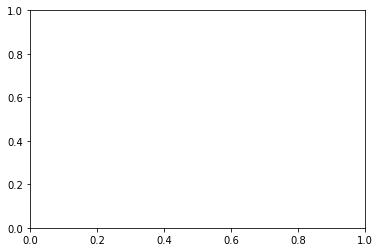

In [18]:
#Comparaison des courbes d'intersection avec paramètres True et False (5mots de similarité)
x=[0,1,2,3]
y_true=(dic_res[True]["intersections"])
y_false=(dic_res[False]["intersections"])
plt.plot(x,y_true,label='True')
plt.plot(x,y_false,label='False')
plt.xlabel("x - Nombre de requêtes")
plt.ylabel("y - Nb de résultats corrects en commun")
plt.title("Comparaison des courbes d'intersection avec paramètres True et False (5mots de similarité)")
plt.legend()
plt.show()
plt.close()
